In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline

In [2]:
# t1 = torch.arange(4)
# t2 = torch.arange(4 , 8)
# print(t1)
# print(t2)
# print(t1+t2)
torch.manual_seed(69)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class Model(nn.Module):
    # IL(4) => HL1 => HL2 => OL(3)
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        # x = F.leaky_relu(self.fc1(x))
        # x = F.leaky_relu(self.fc2(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [4]:
model = Model()
model.to(device)
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
df = pd.read_csv(url)

In [5]:
# extract the features and labels
X = df.drop('species', axis=1)
y = df['species']

# convert the features and labels to tensors
X = torch.tensor(X.values).float()
y = torch.tensor(pd.get_dummies(y).values).float()
# move the features and labels to the GPU
X, y = X.to(device), y.to(device)

In [6]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69) 

In [7]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 500
losses = []

In [8]:
for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, torch.max(y_train, 1)[1])
    losses.append(loss)
    if i % 100 == 0:
        print(f'Epoch {i} and loss is: {loss}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 and loss is: 1.0933917760849
Epoch 100 and loss is: 0.06658606231212616
Epoch 200 and loss is: 0.054417453706264496
Epoch 300 and loss is: 0.05150723084807396
Epoch 400 and loss is: 0.05018587037920952


In [9]:
# test the model
with torch.no_grad():
    y_val = model.forward(X_test)
    # print(y_val, y_test)
    loss = criterion(y_val, torch.max(y_test, 1)[1])
    print(f'Loss: {loss}')

    correct = 0
    for i, data in enumerate(y_val):
        if torch.argmax(data) == torch.argmax(y_test[i]):
            correct += 1
    print(f'Accuracy: {correct/len(y_val)}')

Loss: 0.010746931657195091
Accuracy: 1.0


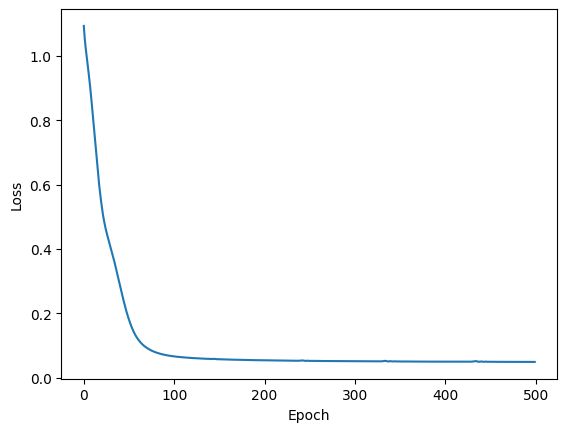

In [10]:
#plot the loss
losses_cpu = [loss.cpu().item() for loss in losses]
plt.plot(range(epochs), losses_cpu)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()